# **ETPoF** Homework 2
Annemarie Linnenbank & Tommie Verouden

*8 March 2024*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.spatial as spatial
from sklearn.cluster import DBSCAN

## Part a: Optical Calibration (13 points)

In this part, we work towards a fully-fledged optical calibration function. For clarity, we will go through all the steps contained within the function in the exercises, so we can show some intermediate results too. The full function is added after part 2a3 - it functions identically to the results.

### 2a1) **Image resolution** (5 pts)

We start by importing the image using the OpenCV library.

In [2]:
# Import the first image in grayscale
img_path = "Images/Calibration_a/Clean.png"
img = cv.imread(img_path, 0)

#### (i) Circle detection

We apply a Hough circle transform to detect circles in the image, after which we remove circles that overlap with the image border. The parameters of the detector have been determined empirically, and we used the `HOUGH_GRADIENT_ALT` algorithm, since it is supposed to be more accurate (see https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65aad57c72131c801de427f1fdb55c8c8ad).

The distance and radii parameters are estimated by counting the circles per pixel by eye.

In [3]:
def detect_circles(img_edges, min_dist, min_radius, max_radius, algorithm = cv.HOUGH_GRADIENT_ALT,
                   dP = 1.5, canny_thresh = 100, parameter2 = 0.8, boundary_px = 0,
                   verbose = False):
    '''Detect circles in an edge-detected image using the Hough transform

    PARAMETERS:
        img_edges (np.array): The edge-detected image
        min_dist (int): Minimum distance between the centers of the detected circles
        min_radius (int): Minimum radius of the detected circles
        max_radius (int): Maximum radius of the detected circles
        dP (int): Inverse ratio of the accumulator resolution to the image resolution
        canny_thresh (int): The upper threshold for the Canny edge detector
        parameter2 (int): How circular the circles should be in the ALT algorithm

    RETURNS:
        circles (np.array): The detected circles
    '''

    # === DETECTION ===
    # Apply Hough transform on the edge-detected image
    circles = cv.HoughCircles(img_edges, algorithm,
                              dP, min_dist, param1 = canny_thresh, param2 = parameter2,
                           minRadius = min_radius, maxRadius = max_radius)
    
    # Warn when no circles are detected
    if circles is None:
        print('No circles detected!')
        return None, None
    elif verbose:
        print(f'{len(circles[0, :, :])} circles detected')
    
    # Convert the circles to a list, split array
    circles = circles[0, :, :]
    centers = circles[:,0:2]
    radii = circles[:,2]


    # === MASKING ===
    # Get the indices of circles that overlap with the image boundary
    overlapping = (centers[:,0] - radii - boundary_px < 0) | \
                    (centers[:,0] + radii + boundary_px > img_edges.shape[0]) | \
                    (centers[:,1] - radii - boundary_px < 0) | \
                    (centers[:,1] + radii + boundary_px > img_edges.shape[1])
    
    # Remove the overlapping circles from the lists
    centers = centers[~overlapping]
    radii = radii[~overlapping]

    # Return the center coordinates and circle radii
    return centers, radii

In [4]:
def plot_circles(img, centers, radii, inset = [0, 100], title = 'Detected circles'):
    '''Plot circles on an RGB image with inset zoom.

    PARAMETERS:
        img (np.array): The image
        centers (np.array): The center coordinates of the circles
        radii (np.array): The radii of the circles
        inset (list): The inset zoom parameters
    '''

    # Convert the image to RGB
    img_rgb = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

    # Plot the circles on the original image
    fig, ax = plt.subplots()
    for center, radius in zip(centers, radii):
        cv.circle(img_rgb, (center[0].astype(int), center[1].astype(int)),
                  radius.astype(int), (0, 255, 0), 2)

    ax.imshow(img_rgb)

    ax.set_title(title)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')

    # Make an inset of the top left corner of the image
    if inset is not None:
        ax.add_patch(plt.Rectangle((inset[0], inset[0]), inset[1]-inset[0], inset[1]-inset[0],
                    fill=False, color='b', linewidth=2))
        axins = ax.inset_axes([0.12, 0.37, 0.5, 0.5], xlim=inset, ylim=np.flip(inset), xticks=[], yticks=[])
        axins.imshow(img_rgb, cmap='gray', origin="upper")
        axins.scatter(centers[:, 0], centers[:, 1], c="g", s=100, marker="+")
        axins.spines[:].set_color('blue')
        axins.spines[:].set_linewidth(2)

    # Show the image
    plt.imshow(img_rgb)    

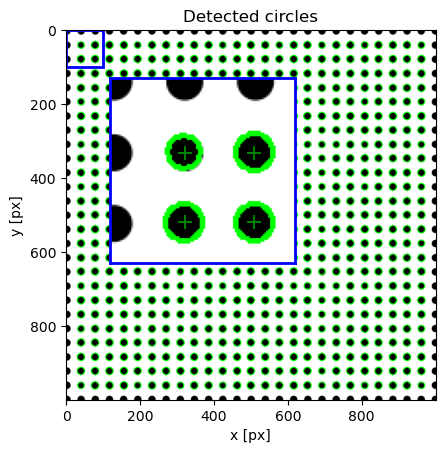

In [5]:
# Detect circles in the image
cent_px, radii_px = detect_circles(img, min_dist=10, min_radius=5, max_radius=20)

# Plot the circles on the original image
plot_circles(img, cent_px, radii_px)


Note that the circles can only be drawn on the image with a full pixel accuracy on both the radius and the center. There is, however, some inaccuracy present in the Hough transform, since it is limited to 0.5 px when determining the center coordinates. A more accurate approach might be the FindCirclesGrid() algorithm in the OpenCV library, which we will later compare the result to.

First, we calculate the Euclidian distances between all points, $d = \sqrt{x^2+y^2}$.

In [6]:
def calc_distance_between_all_points(x, y):
    '''Calculate the distance between all points in a 2D space

    PARAMETERS:
        x (np.array): The x-coordinates of the points
        y (np.array): The y-coordinates of the points

    RETURNS:
        distances_px (np.array): The distances between all points
    '''
    
    xy = np.column_stack([x, y])

    # Calculate the distance between all points
    distances_px = spatial.distance.cdist(xy, xy, 'euclidean')

    return distances_px

# Calculate the distance between all points
dist_px = calc_distance_between_all_points(cent_px[:, 0], cent_px[:, 1])

From these distances and the given calibration distance, we would like to calculate the resolution. However, for that, we need to know how many dots are actually spanned by the distances in the `dist_px` matrix. One problem: the output of the Hough transform is in an arbitrary order. Therefore, we first sort the coordinates by x and y values.

In [7]:
# Sort the coordinates by x and y
cent_px_sort = cent_px[np.lexsort((cent_px[:, 0], cent_px[:, 1]))]

# Calculate the distance between all points
dist_px_sort = calc_distance_between_all_points(cent_px_sort[:, 0], cent_px_sort[:, 1])

# Get the grid size from the uniqueness of the x and y coordinates
grid_size_id = [np.unique(cent_px_sort[:, 0]).size, np.unique(cent_px_sort[:, 1]).size]

This straightforward sorting operation only works in this case because, as it turns out, the coordinates could all be determined with 0.5 px precision, meaning that the x-coordinates of the dots in each column (and y-coordinates in each row) are exactly equal. Later, we will show a more robust method.

#### (ii) Resolution calculation

From the sorting indices of each circle, we can calculate the distance in "dot units". Combined with the calibration distance, we obtain the distances converted to real space, which, divided by the distance in pixel-space, give us a measure for the resolution of the image - calculated for every possible combination of circles.

In [8]:
def calc_resolution(dist_px, dist_id, calibration_distance = 1):
    '''Calculate the resolution of the image in pixels per unit length

    PARAMETERS:
        dist_px (np.array): The distance between all points in pixels
        dist_id (np.array): The distance between all points in index space
        calibration_distance (int): The distance between the calibration points in mm

    RETURNS:
        resolution (float): The resolution of the image in pixels per unit length
    '''

    # The real distance is given by the distance between
    #  two neighbouring points in real space times the distance in dot-space
    dist_re = calibration_distance * dist_id

    # Because the distance between a point and itself is 0, we ignore the division by zero warning
    with np.errstate(divide='ignore', invalid='ignore'):
        # Calculate the resolution of the image in pixels per unit length
        res = dist_re / dist_px

    return res

In [9]:
calibration_distance = 5 # mm

# Generate the grid in index space
cent_id_sort = np.fliplr(np.indices(grid_size_id).reshape(2, -1).T)

# Calculate the dot-space distances
dist_id_sort = calc_distance_between_all_points(cent_id_sort[:, 0], cent_id_sort[:, 1])

# Calculate the resolution for each distance
res = calc_resolution(dist_px_sort, dist_id_sort, calibration_distance)

Assuming that the grid is not distorted (for now), we can take the average resolution as a measure for the resolution of the entire image. Since the error scales with $1/d$, we can use a weighted average where we weigh the points by distance. So the resolution calculated from two neighbouring points weighs the least, and the diagonals the most.

In [10]:
def weighted_avg_and_std(values, weights, mask_diagonal=True, verbose=False):
    """
    Calculate the weighted average and standard deviation of a set of values.

    PARAMETERS:
        values (array-like): The values for which to calculate the weighted average and standard deviation.
        weights (array-like): The weights corresponding to each value.

    RETURNS:
        tuple: A tuple containing the weighted average and standard deviation.
    """

    # Mask the diagonal to avoid division by zero
    if mask_diagonal:
        mask = np.eye(values.shape[0], dtype=bool).__invert__()

    # Calculate the weighted average
    average = np.average(values[mask], weights=weights[mask])

    # Calculate the weighted variance
    variance = np.average((values[mask]-average)**2, weights=weights[mask])

    if verbose:
        print(f"The average resolution is {average:.5f} mm/px " + \
              f"with a standard deviation of {np.sqrt(variance):.5f} mm/px.")

    # Output the average and standard deviation
    return (average, np.sqrt(variance))

In [11]:
res_avg, res_std = weighted_avg_and_std(res, dist_id_sort, verbose=True)

The average resolution is 0.13054 mm/px with a standard deviation of 0.00020 mm/px.


We think the standard deviation in the resolution gives a good estimate of the error in the calibration algorithm. It would be good if a measure of certainty could be extracted from the `cv.HoughCircles` function to compare the standard deviation to. Another option would be to extrapolate the position (in pixels) of the circles, based on the calculated resolution and the horizontal and vertical indices. The difference in position with the real position would also be a measure of the error in our algorithm.

#### (iii) Accuracy comparison

As a final check, we will compare the above error to the "off-the-shelf" `cv.findCirclesGrid` function, which compresses a few steps into one (with less control, however). Besides simplicity, the main advantage would be accuracy, because it is able to output the circle centres with sub-pixel precision. A disadvantage is that it requires *a priori* knowledge of the grid size, which is not unrealistic in a real experiment, but we did manage to circumvent that in the above steps.

In [12]:
# Find a symmetric circle grid using opencv
grid_found, cent_blackbox = cv.findCirclesGrid(
    img, grid_size_id, flags=cv.CALIB_CB_SYMMETRIC_GRID)
cent_blackbox = cent_blackbox.reshape(-1, 2)

if grid_found is False:
    print('No grid found!')
else:
    # Calculate the distance between all points
    dist_px_blackbox = calc_distance_between_all_points(cent_blackbox[:, 0], cent_blackbox[:, 1])

    # Calculate the resolution for each distance
    res_blackbox = calc_resolution(dist_px_blackbox, dist_id_sort, calibration_distance)

    # Calculate the weighted average and standard deviation
    res_avg_blackbox, res_std_blackbox = weighted_avg_and_std(res_blackbox, dist_id_sort, verbose=True)

The average resolution is 0.13055 mm/px with a standard deviation of 0.00001 mm/px.


This result is indeed more precise, but also well within the error margin of our "manual" calculation.

### 2a2) **Noise, rotation & lens vignetting** (8 pts)

In this part we will elaborate on the steps taken in part 2a1. Start, again, by importing the image, and setting a new calibration size.

In [13]:
# Clear all variables without removing the imported modules
del [[cent_px, radii_px, cent_px_sort, dist_px, dist_px_sort,
      grid_size_id, cent_id_sort, dist_id_sort, res,
      calibration_distance, grid_found, cent_blackbox,
      dist_px_blackbox, res_blackbox, res_avg,
      res_std, res_avg_blackbox, res_std_blackbox]]

# Import the second image in grayscale
img_path = "Images/Calibration_a/Realistic.png"
img = cv.imread(img_path, 0)

# Set the calibration distance to 2 mm
calibration_distance = 2 # mm

#### (i) Noise & vignetting correction
Let us see what is going on in the image by making a histogram of the pixel intensities.

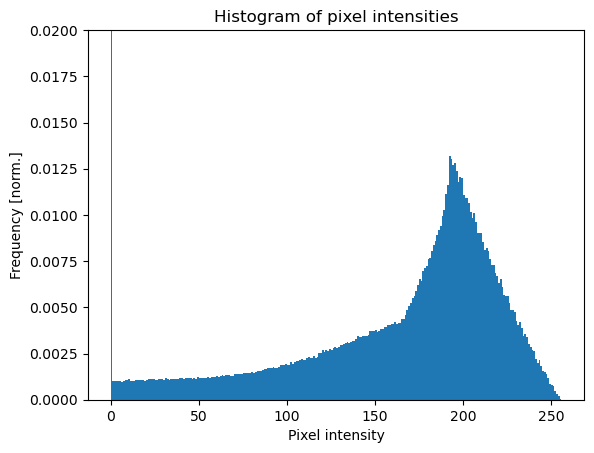

The fraction of pixels at zero intensity is 0.0904.


In [14]:
# Make a histogram of the image
fig, ax = plt.subplots()
ax.hist(img.ravel(), bins=256, range=[0,256], density=True)
ax.set_title('Histogram of pixel intensities')
ax.set_xlabel('Pixel intensity')
ax.set_ylabel('Frequency [norm.]')
ax.set_ylim([0, 0.02])
plt.show()

# Print the fraction of pixels at zero intensity 
print(f'The fraction of pixels at zero intensity is {np.sum(img == 0) / img.size:.4f}.')

It is clear that the circles will be mostly contained in the large peak at zero intensity (which, in the plot above is cropped; it actually goes up to ~0.09.). The background noise is mostly spread out in intensity. Therefore, we can safely apply some contrast or brightness changes.

In the end, we settled on the following order of operations to enhance the image:
1. Start by applying a Gaussian blur to get rid of any sharp features in the background. The radius of the kernel was chosen empirically.
2. Increase the contrast of the image slightly using the OpenCV library to add and clip images.
3. Binarise the (greyscale) image with an adaptive threshold. This way, we can separate the dots from the background. To be extra safe, an adaptive threshold was chosen to account for the vignetting in the image, which causes the background to be darker at the edges. From the histogram, we could see that this might not have been necessary in this case, but it does not hurt either, as long as the kernel used to calculate the average brightness is large enough. We have chosen the constant which `cv.adaptiveThreshold` subtracts from this value (to determine the local threshold) empirically.
4. Next, we close the image with a circular kernel to remove some small artefacts from the background. This is done by first dilating and then eroding the image.
5. Then, we open the image up to fill small holes that are left in the black circles. The same (small) kernel is used as in step 4.

Note that, in the end, step 4 and 5 do not add much, since we managed to tweak the other parameters well enough that the circles were already well-separated after step 3. We have kept them here for future reference.

#TODO EDIT

For some of the ways in which we tried to solve the problem below, it proved to be useful to perform Canny edge detection on the image. This is added as an optional 6th step.

In [15]:
def pre_process(img, blur_kernel = 9, contrast = 1.2, brightness = 0,
                binary_kernel_radius = 31, binary_constant = 51, morph_kernel_radius = 5,
                plot = False, canny_edges = False, canny_thresh = 70, canny_max = 255):
    '''Pre-process an image for circle detection
    
    PARAMETERS:
        img (np.array): The image to pre-process
        blur_kernel (int): The size of the Gaussian blur kernel
        contrast (float): The contrast enhancement factor
        brightness (int): The brightness enhancement factor
        binary_kernel_radius (int): The radius of the adaptive thresholding kernel
        binary_constant (int): The constant of the adaptive thresholding
        morph_kernel_radius (int): The radius of the morphological kernel
        plot (bool): Whether to plot the pre-processing steps
        canny_edges (bool): Whether to use Canny edge detection
        canny_thresh (int): The upper threshold for the Canny edge detector
        canny_max (int): The maximum value of the Canny edge detector
        
    RETURNS:
        img_proc (np.array): The pre-processed image
    '''
    
    # Make a copy of the image
    img_proc = img.copy()

    if plot:
        # Set up a plot, show original image (1)
        fig, ax = plt.subplots(2, 3, figsize=(8, 4))
        ax[0, 0].imshow(img_proc, cmap='gray')

    # Apply a Gaussian blur (2)
    img_proc = cv.GaussianBlur(img_proc, (blur_kernel, blur_kernel), 0)
    if plot: ax[0, 1].imshow(img_proc, cmap='gray')

    # Increase the contrast (3)
    img_proc = cv.addWeighted(
        img_proc, contrast, img_proc, brightness, 0)
    if plot: ax[0, 2].imshow(img_proc, cmap='gray')

    # Binarize the image with adaptive threshold (4)
    img_proc = cv.adaptiveThreshold(
        img_proc, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, binary_kernel_radius, binary_constant)
    if plot: ax[1, 0].imshow(img_proc, cmap='gray')

    # Close the image with a circular kernel to remove small components (5)
    kernel = cv.getStructuringElement(
        cv.MORPH_ELLIPSE, (morph_kernel_radius, morph_kernel_radius))
    img_proc = cv.dilate(img_proc, kernel)
    img_proc = cv.erode(img_proc, kernel)

    # Open the image with the same kernel to fill small holes
    img_proc = cv.erode(img_proc, kernel)
    img_proc = cv.dilate(img_proc, kernel)
    if plot: ax[1, 1].imshow(img_proc, cmap='gray')

    # Edge detection (6)
    if canny_edges:
        img_proc = cv.Canny(img_proc, canny_thresh, canny_max)
    else:
        img_proc = np.zeros_like(img_proc)
    if plot: ax[1, 2].imshow(img_proc, cmap='gray')

    if plot:
        # Finish the plot
        subplot_names = ['Original', 'Gaussian blur',
                    'Increase contrast', 'Binarize',
                    'Close + open', '']
        if canny_edges:
            subplot_names[5] = 'Canny edges'

        for ii, a in enumerate(ax.flatten()):
            a.set_xticks([])
            a.set_yticks([])
            a.set_xlim([105, 215])
            a.set_ylim([120, 10])
            a.set_title(subplot_names[ii])

        ax[1,0].set_xticks([150, 200])
        ax[1,0].set_yticks([50, 100])
        plt.show()

    return img_proc

The intermediate results are shown on a cutout of the top-left corner of the image in the plots below. The vertical axis seems to have flipped accidentally.

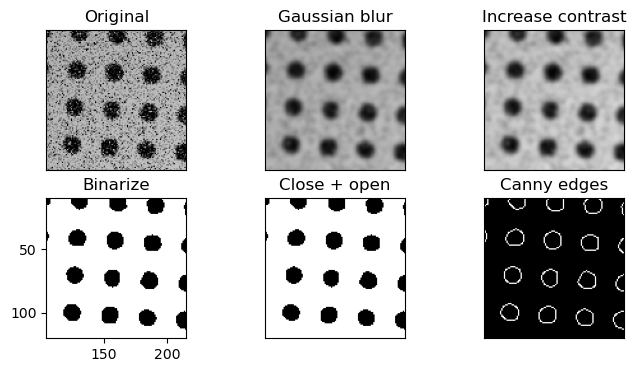

In [16]:
# Pre-process the image
img_proc = pre_process(img, plot=True, canny_edges=True)

#### (ii) Circle detection

This time, we search for smaller circles. Therefore, we decrease the minimum radius, as well as the parameter dP, which accounts for how the accumulator space is defined relative to the image space. In the accumulator space, possible circle candidates are determined, so a higher resolution can help when detecting small circles (see https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d).

We have also changed to the regular `cv.HOUGH_GRADIENT` algorithm, since it seems to be more robust to the jagged edges in our image, despite the pre-processing.

1145 circles detected


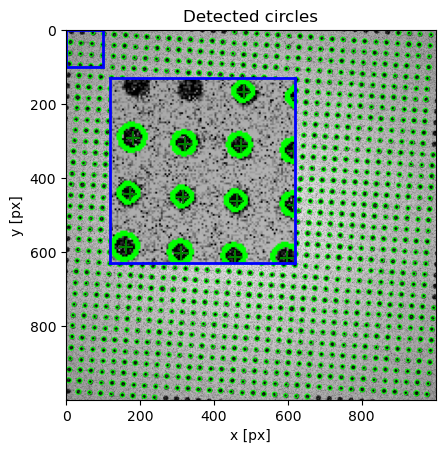

In [17]:
# Detect circles in the processed image
cent_px, radii_px = detect_circles(img_proc, algorithm = cv.HOUGH_GRADIENT,
                                   dP = 1, min_dist = 10, min_radius = 5, max_radius = 14,
                                   canny_thresh = 140, parameter2 = 12,
                                   verbose=True)
                                   
# Plot the circles on the original image
plot_circles(img, cent_px, radii_px)

#### (iii) Rotation correction
Our code from part 2a1 requires a rectangular grid of circles. Due to the rotation in the image, the number of circles in each row and column varies now. Thus, we would like to remove the "incomplete" rows and columns. Let us try to find the angle.

We start by generating an image containing only the circle centres as white pixels on a black background. Because these coordinates are (often) in between pixels, we colour the pixels around the centres too, when necessary. Then we apply the Hough line transform with a 1 pixel and 0.1 degree resolution. A minimum of 40 votes is chosen such that only horizontal, vertical and diagonal lines show up (they hit at least 40 white pixels, which would amount to at least 10 circles where the centre is in between 4 pixels).

From these lines, the ones with the most common angle (after clustering) are used to calculate an average value and error. Because the circles centres can be a group of 2 or 4 pixels in the generated image, more horizontal and vertical lines than diagonals can be drawn through them. So for angles smaller than 45°, we are likely to avoid accidentally extracting the angle of the diagonals.

In [18]:
def calc_angle(img, centers, res_px = 1, res_deg = 0.1, min_votes = 40,
               plot = False, verbose = False):
    '''Calculate the angle of the circles in the image

    PARAMETERS:
        img (np.array): The image
        centers (np.array): The center coordinates of the circles
        res_px (int): The resolution of the Hough line transform in pixels
        res_deg (int): The resolution of the Hough line transform in degrees
        min_votes (int): The minimum number of votes for a line to be considered
        plot (bool): Whether to plot the detected lines
        verbose (bool): Whether to print the results

    RETURNS:
        angle_avg (float): The average angle of the grid in radians
        angle_std (float): The standard deviation of the angle in radians
        angle_ct (int): The number of lines used to calculate the angle
        lines_ct (int): The total number of lines detected
    '''

    # === CIRCLE CENTER GRID ===
    # Generate a black image
    img_centers = np.zeros_like(img)

    # Get the pixel indices surrounding the circle centres,
    # and clip them to the image size
    x = [np.clip(np.floor(centers[:,0]).astype(int), 0, img.shape[1]-1),
            np.clip(np.ceil(centers[:,0]).astype(int), 0, img.shape[1]-1)]
    y = [np.clip(np.floor(centers[:,1]).astype(int), 0, img.shape[0]-1),
            np.clip(np.ceil(centers[:,1]).astype(int), 0, img.shape[0]-1)]

    # Color these pixels white
    img_centers[y[0], x[0]] = img_centers[y[1], x[1]] \
        = img_centers[y[0], x[1]] = img_centers[y[1], x[0]] = 255

    # === HOUGH LINE TRANSFORM ===
    # Perform a Hough line transform
    lines = cv.HoughLines(img_centers, res_px, res_deg * np.pi / 180, min_votes)

    # Make a plot of the lines
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(img_centers, cmap='gray')

        # Plot the lines
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta); b = np.sin(theta)
            x0 = a * rho; y0 = b * rho
            x1 = int(x0 + 2 * img.shape[0] * (-b))
            y1 = int(y0 + 2 * img.shape[1] * (a))
            x2 = int(x0 - 2 * img.shape[0] * (-b))
            y2 = int(y0 - 2 * img.shape[1] * (a))
            ax.plot([x1, x2], [y1, y2], 'y', linewidth=1)

        ax.set_title('Detected lines')
        ax.set_xlabel('x [px]')
        ax.set_ylabel('y [px]')
        ax.set_xlim([0, img.shape[0]])
        ax.set_ylim([img.shape[1], 0])
        plt.show()

    # === PROCESSING ===
    # Extract angles in degrees
    lines_angles = np.array([line[0][1] / np.pi * 180 for line in lines])

    # Round to the nearest 1 degree and consider multiples of 90 degrees
    lines_angles = np.round(np.mod(lines_angles, 90), 1)

    # Use the DBSCAN algorithm to cluster the angles
    dbscan = DBSCAN(eps=1, min_samples=2)
    dbscan.fit(lines_angles.reshape(-1, 1))

    # Get the number of clusters
    angles_ids, angles_cts = np.unique(dbscan.labels_, return_counts=True)

    # If only two angles are left
    if len(angles_cts) == 2:
        # Calculate the average of the angles in the largest bin
        # (assuming non-diagonal lines get more hits with non-singular points)
        angles = [lines_angles[dbscan.labels_ == angles_ids[angles_cts.argmax()]]]
        angle_avg = np.mean(angles)
        angle_std = np.std(angles)

        # Also get the number of elements in the smallest cluster
        angle_ct = angles_cts[angles_cts.argmax()]

        if verbose:
            print(f"The angle of the grid in the image is {angle_avg:.1f}°"\
                  f" with a standard deviation of {angle_std:.1f}°.")
            print(f"This was calculated using {angle_ct}/{len(lines_angles)} lines found.")

        # Convert back to radians
        angle_avg = angle_avg / 180 * np.pi
        angle_std = angle_std / 180 * np.pi

        return angle_avg, angle_std, angle_ct, len(lines_angles)
    
    # If no or more than two angles are found, return None
    else:
        if verbose:
            print('Too little or too many lines found, try changing the min_votes.')
        return None, None, None, None


Note that for the clustering, we added a small machine learning part. This solution might be a bit overkill, but it is quick and reliable: we simply cluster the "data points" (in this case line angles) into an unknown number of bins. The algorithm we used is called "Density-Based Spatial Clustering of Applications with Noise" or DBSCAN, which groups neighbouring points together without prior knowledge on the number of clusters (see also https://en.wikipedia.org/wiki/DBSCAN).

We first found it when sorting the grid points (see part iv), where it made slightly more sense to use this function - here the clustering can definitely be done more easily. But we had it imported anyway.

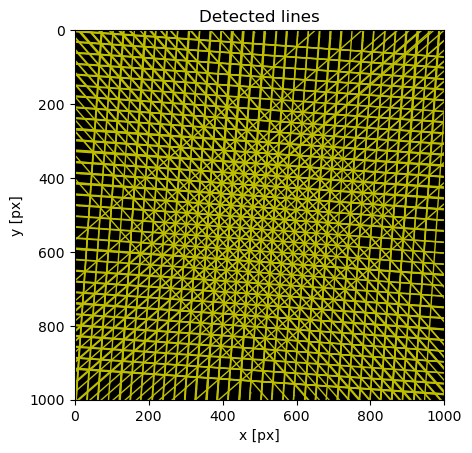

The angle of the grid in the image is 4.0° with a standard deviation of 0.1°.
This was calculated using 183/259 lines found.


In [19]:
# Calculate the angle of the circles in the image
angle_avg, angle_std, angle_ct, line_ct = calc_angle(img_proc, cent_px, plot=True, verbose=True)

Even though we could exploit the embedded possibility of drawing multiple lines here nicely, it does result in a larger-than-necessary error (given that you could, e.g., draw a line from the left pixel of the top circle centre to the right pixel of the bottom centre). There are probably more accurate ways to distinguish diagonals (like matching crossings of orthogonal line sets to the circle centres themselves), but this works for now.

Next, we can use this angle to define a rectangular mask, rotated by the angle that was found, and cut off the incomplete rows.

In [20]:
def mask_grid_rotation(img, cent_px, radii_px, angle,
                       boundary_px=0, plot=False):
    """
    Masks circles in an image that are outside the rotated image.

    PARAMETERS:
        img (numpy.ndarray): The input image.
        cent_px (numpy.ndarray): The coordinates of the circle centers in pixels.
        radii_px (numpy.ndarray): The radii of the circles in pixels.
        angle (float): The angle of rotation in radians.
        boundary_px (int): The boundary in pixels to consider around the rotated image. Default is 0.
        plot (bool): Whether to plot the masked circles. Default is False.

    RETURNS:
        cent_px_mask (numpy.ndarray): The masked circle centers.
        radii_px_mask (numpy.ndarray): The masked circle radii.
    """

    # Get the image size
    img_y, img_x = img.shape

    # Get the circle coordinates
    circles_x = cent_px[:, 0]
    circles_y = cent_px[:, 1]

    # Mask the circles that are outside the rotated image
    mask = (circles_y > radii_px + boundary_px + np.tan(angle) * circles_x) \
           & (circles_y < img_y - radii_px - boundary_px - np.tan(angle) * (img_x - circles_x)) \
           & (circles_x > np.tan(angle) * (img_y - circles_y) + radii_px) \
           & (circles_x < img_x - radii_px - np.tan(angle) * circles_y)
    
    # TODO MAKE THIS WORK FOR NEGATIVE ANGLE

    # Get the masked circles
    cent_px_mask = cent_px[mask]
    radii_px_mask = radii_px[mask]

    # Make a plot of the masked circles
    if plot:
        plot_circles(img, cent_px_mask, radii_px_mask,
                     title='Masked circles', inset=None)

    return cent_px_mask, radii_px_mask

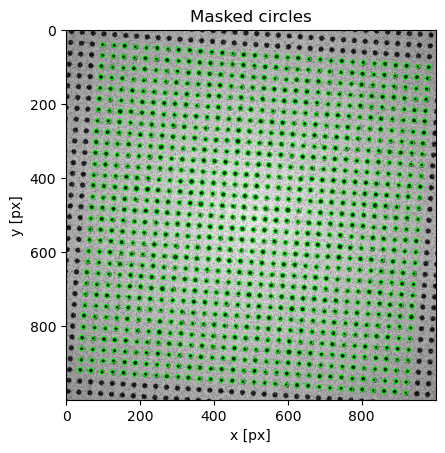

In [21]:
cent_px_mask, radii_px_mask = mask_grid_rotation(img, cent_px, radii_px, angle_avg, plot=True)

Now, we can rotate the grid back!

In [22]:
def rotate_grid(cent, angle, plot=False, img=None):
    """
    Rotate a grid of points around a center point by a given angle.
    
    PARAMETERS:
        cent (numpy.ndarray): The center point of the grid.
        angle (float): The angle (in radians) by which to rotate the grid.
        plot (bool): Whether to plot the rotated grid. Default is False.
        img (numpy.ndarray): The image to rotate around. Default is None.
    
    RETURNS:
        cent_rot (numpy.ndarray): The rotated grid of points.
        img_rot (numpy.ndarray): The rotated image.
    """

    # === CIRCLE CENTER ROTATION ===
    # If the image is not given, rotate around (0,0))
    if img is None:
        # Assume the center is at (0, 0)
        img_center = [0, 0]
    else:
        # Get the image size
        img_y, img_x = img.shape

        # Calculate the center of the image
        img_center = [img_x / 2, img_y / 2]

    # Generate a rotation matrix
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                          [np.sin(angle), np.cos(angle)]])
    
    # Translate, multiply by the rotation matrix and translate back
    cent_tra = cent - img_center
    cent_rot = np.dot(rot_matrix, cent_tra.T)
    cent_rot = cent_rot.T + img_center

    # === IMAGE ROTATION ===
    if img is not None:
        # Rotate the image the openCV way
        rot_matrix = cv.getRotationMatrix2D(img_center, -angle / np.pi * 180, 1)
        img_rot = cv.warpAffine(img, rot_matrix, (img_x, img_y))

        # Make a plot of the rotated image
        if plot and cent is not None:
            # Plot the circles on the rotated image
            plot_circles(img_rot, cent_rot, radii_px_mask, title='Rotated image', inset=None)
    else:
        img_rot = None

    return cent_rot, img_rot

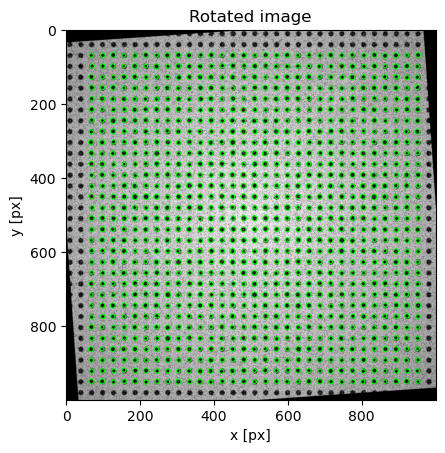

In [23]:
# Calculate the rotated grid of circle coordinates in pixels
# and plot the image as verification
cent_px_rot, img_rot = rotate_grid(cent_px_mask, -angle_avg, plot=True, img=img)

#### (iv) Circle sorting
It is finally time to work towards a resolution calculation. However, due to the rotation, there are now slight inaccuracies in both coordinates, making this not so trivial. 

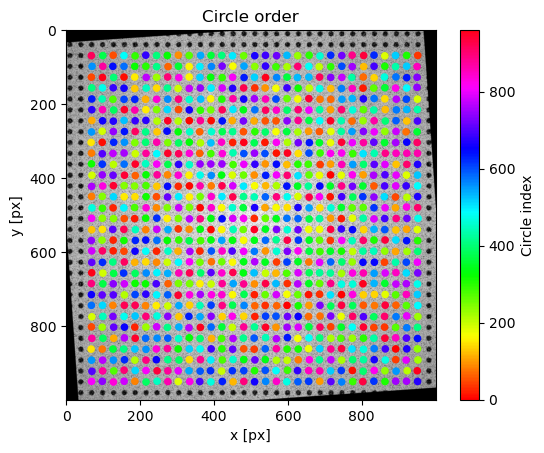

In [24]:
# Plot the circle centers with a color corresponding to the index
fig, ax = plt.subplots()
ax.imshow(img_rot, cmap='gray')
ax.scatter(cent_px_rot[:, 0], cent_px_rot[:, 1], 
           c=range(len(cent_px_rot)), s=20,
           cmap = 'hsv')
ax.set_title('Circle order')
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

# Add a colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical')
cbar.set_label('Circle index')
plt.show()

Like in part iii, we pull out the DBSCAN function to cluster the points twice: first in the x-direction, and then in the y-direction.

In [25]:
def sort_circles(cent_px, radii_px):
    # Sort the circle coordinates by x
    cent_px_sort = cent_px.copy()
    cent_px_sort = cent_px_sort[cent_px_sort[:, 0].argsort()]

    # Minimum distance between clusters is the average circle diameter
    min_dist = 2 * np.mean(radii_px)

    # Perform clustering in the x direction, fit model to data
    dbscan_x = DBSCAN(eps=min_dist, min_samples=2)
    dbscan_x.fit(cent_px_sort[:, 0].reshape(-1, 1))

    # Make an array of the cluster numbers in the x direction for each circle
    cent_id = dbscan_x.labels_

    # Sort the data points and the clusters array by y coordinate
    sort_y = cent_px_sort[:, 1].argsort()
    cent_px_sort = cent_px_sort[sort_y]
    cent_id = cent_id[sort_y]

    # Perform clustering in the y direction, fit model to data
    dbscan_y = DBSCAN(eps=min_dist, min_samples=2)
    dbscan_y.fit(cent_px_sort[:, 1].reshape(-1, 1))

    # Add a dimension to the clusters array
    cent_id = np.vstack((cent_id, dbscan_y.labels_)).T

    indices = np.lexsort((cent_id[:, 0], cent_id[:, 1]))
    cent_id = cent_id[indices]

    # Sort the circle coordinates and radii by the cluster indices
    cent_px_sort = cent_px_sort[indices]
    radii_px_sort = radii_px[indices]

    # Count the number of clusters
    grid_size_id = [len(np.unique(dbscan_x.labels_)), len(np.unique(dbscan_y.labels_))]

    return cent_px_sort, radii_px_sort, cent_id, grid_size_id  

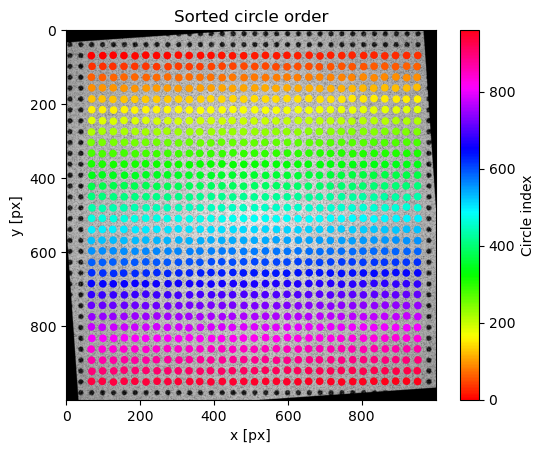

In [26]:
# Sort the circle coordinates and radii
cent_px_sort, radii_px_sort, cent_id, grid_size_id = sort_circles(cent_px_rot, radii_px_mask) 

# Plot the circle centers with a color corresponding to the index
fig, ax = plt.subplots()
ax.imshow(img_rot, cmap='gray')
ax.scatter(cent_px_sort[:, 0], cent_px_sort[:, 1], 
           c=range(len(cent_px_sort)), s=20,
           cmap = 'hsv')
ax.set_title('Sorted circle order')
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

# Add a colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical')
cbar.set_label('Circle index')
plt.show()

#### (v) Resolution calculation

Now, we rotate the coordinates back, and perform the same steps as in part 2a1 to obtain the resolution of the image.

In [27]:
# Rotate the grid back to the original orientation
cent_px_sort, _ = rotate_grid(cent_px_sort, angle_avg)

# Calculate the distance between all points in real space and index space
dist_px_sort = calc_distance_between_all_points(cent_px_sort[:, 0], cent_px_sort[:, 1])
dist_id_sort = calc_distance_between_all_points(cent_id[:, 0], cent_id[:, 1])

# Calculate the resolution for each distance
res = calc_resolution(dist_px_sort, dist_id_sort, calibration_distance)

# Calculate the weighted average and standard deviation
res_avg, res_std = weighted_avg_and_std(res, dist_id_sort, verbose=True)

The average resolution is 0.06803 mm/px with a standard deviation of 0.00016 mm/px.


### 2a3) **Radially-varying resolution**

Now, the image is also distorted! We start by repeating steps (i) - (iv) from part 2a2.

In [28]:
# Clear all variables without removing the imported modules
del [[angle_avg, angle_ct, angle_std, cent_id,
      cent_px, cent_px_mask, cent_px_rot, cent_px_sort,
      dist_id_sort, dist_px_sort, grid_size_id,
      img_proc, img_rot, line_ct, radii_px,
      radii_px_mask, radii_px_sort, res, res_avg,
      res_std]]

# Import the third image in grayscale
img_path = "Images/Calibration_a/Distorted.png"
img = cv.imread(img_path, 0)

# Set the calibration distance to 4 mm
calibration_distance = 4 # mm



The angle of the grid in the image is 88.0° with a standard deviation of 0.9°.
This was calculated using 98/134 lines found.


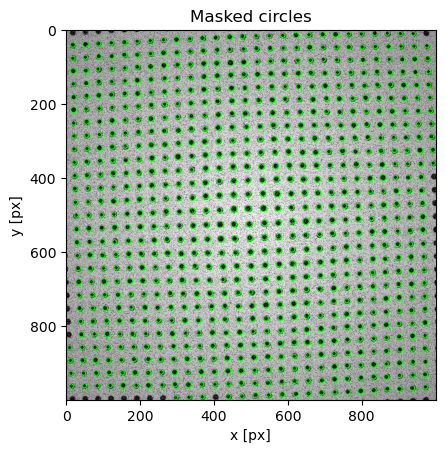

In [29]:
# Pre-process the image
img_proc = pre_process(img, plot=False, canny_edges=True)

# Detect circles in the processed image
cent_px, radii_px = detect_circles(img_proc, algorithm = cv.HOUGH_GRADIENT,
                                   dP = 1, min_dist = 10, min_radius = 5, max_radius = 14,
                                   canny_thresh = 140, parameter2 = 12)

# Calculate the angle of the circles in the image
angle_avg, angle_std, angle_ct, line_ct = calc_angle(img_proc, cent_px, min_votes = 25, plot=False, verbose=True)

# TODO EXPLAIN THIS - ALSO DOES NOT WORK FOR NEGATIVE ANGLES
angle_avg = angle_avg - (np.pi / 2)

# Mask the circles that are outside the rotated image
cent_px_mask, radii_px_mask = mask_grid_rotation(img, cent_px, radii_px, angle_avg, plot=True)

# # Calculate the rotated grid of circle coordinates in pixels
# cent_px_rot, img_rot = rotate_grid(cent_px_mask, -angle_avg, plot=True, img=img)

# # Sort the circle coordinates and radii
# cent_px_sort, radii_px_sort, cent_id, grid_size_id = sort_circles(cent_px_rot, radii_px_mask)

# # Rotate the grid back to the original orientation
# cent_px_sort, _ = rotate_grid(cent_px_sort, angle_avg)

# # Calculate the distance between all points in real space and index space
# dist_px_sort = calc_distance_between_all_points(cent_px_sort[:, 0], cent_px_sort[:, 1])
# dist_id_sort = calc_distance_between_all_points(cent_id[:, 0], cent_id[:, 1])

### **Full optical calibration function**